In [1]:
%%html
<iframe style="aspect-ratio: 1200 / 630; width:100%; height:fit-content;" src="https://www.coindesk.com/embedded-chart/GRdgwdpLtpFTd" width="100%" frameborder="0" scrolling="no"></iframe>

# Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import sys
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from utils import \
    get_binance_klines, \
    plot_time_series, \
    custom_plot_series, \
    evaluate_preds, \
    get_labelled_windows, \
    make_windows, \
    make_train_test_splits

# Get Data

In [4]:
symbol = 'BTCUSDT'
interval = '1d'
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

df = get_binance_klines(symbol, interval, start_date, end_date)

if df is not None:
    # Define the full path to the file in the data folder
    data_dir = '../data/'
    csv_file = os.path.join(data_dir, 'binance_btcusdt_price_history.csv')
    
    # Save the data to a CSV file in the data folder
    df.to_csv(csv_file, index=False)
    print(f"Historical Bitcoin price data from Binance downloaded and saved to '{csv_file}'")

    # Get the last element of the DataFrame
    last_element = df.iloc[-1]
    print("\nLast element of the DataFrame:")
    print(last_element)

Historical Bitcoin price data from Binance downloaded and saved to '../data/binance_btcusdt_price_history.csv'

Last element of the DataFrame:
open                                60986.68000000
high                                62270.00000000
low                                 60712.21000000
close                               62270.00000000
volume                              12908.40773000
close_time                           1719791999999
quote_asset_volume              793873359.83907940
number_of_trades                            824180
taker_buy_base_asset_volume          5993.14068000
taker_buy_quote_asset_volume    368606330.82610280
ignore                                           0
Name: 2024-06-30 00:00:00, dtype: object


The bitcoin historical data in [Binance](https://www.binance.com/en) starts in **2017-08-17**

In [5]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
Date,,,,,,,,,,,
2017-08-17,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
2017-08-18,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2017-08-19,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
2017-08-20,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
2017-08-21,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2510 entries, 2017-08-17 to 2024-06-30
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open                          2510 non-null   object
 1   high                          2510 non-null   object
 2   low                           2510 non-null   object
 3   close                         2510 non-null   object
 4   volume                        2510 non-null   object
 5   close_time                    2510 non-null   int64 
 6   quote_asset_volume            2510 non-null   object
 7   number_of_trades              2510 non-null   int64 
 8   taker_buy_base_asset_volume   2510 non-null   object
 9   taker_buy_quote_asset_volume  2510 non-null   object
 10  ignore                        2510 non-null   object
dtypes: int64(2), object(9)
memory usage: 235.3+ KB


In [7]:
len(df)

2510

In [8]:
btc_prices = pd.DataFrame(df['close']).rename(columns={'close': 'Price'})
btc_prices['Price'] = btc_prices['Price'].astype(float)
btc_prices.head()

,Price
Date,
2017-08-17,4285.08
2017-08-18,4108.37
2017-08-19,4139.98
2017-08-20,4086.29
2017-08-21,4016.00


### Visualize !

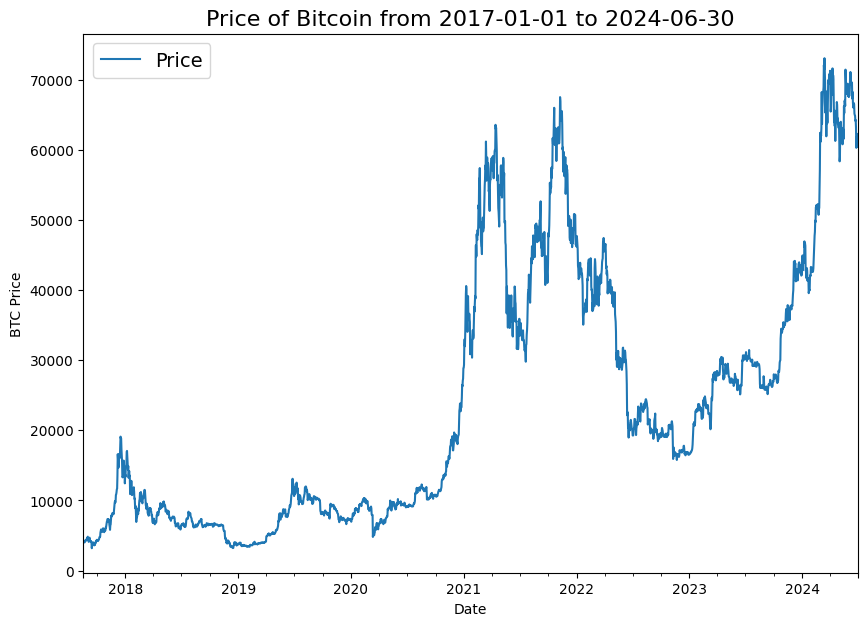

In [9]:
btc_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title(f"Price of Bitcoin from {start_date} to {end_date}", fontsize=16)
plt.legend(fontsize=14);

# Create train & test sets for time series

In [10]:
# Get bitcoin date array
timesteps = btc_prices.index.to_numpy()
prices = btc_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2017-08-17T00:00:00.000000000', '2017-08-18T00:00:00.000000000',
        '2017-08-19T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
        '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
        '2017-08-23T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
        '2017-08-25T00:00:00.000000000', '2017-08-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([4285.08, 4108.37, 4139.98, 4086.29, 4016.  , 4040.  , 4114.01,
        4316.01, 4280.68, 4337.44]))

In [11]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2008, 502, 2008, 502)

Let's visualize

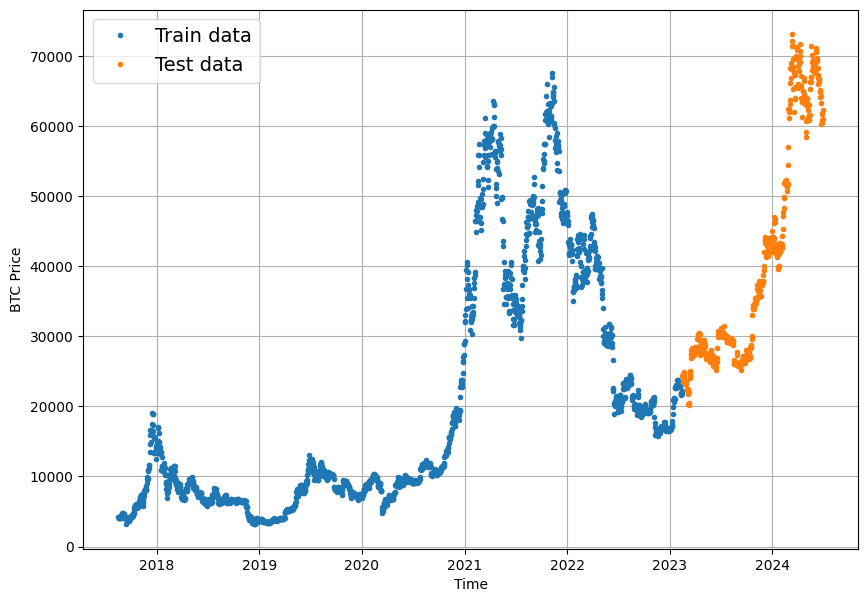

In [12]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling Experiments

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict **horizon**

<table style="width: 100%">
    <tr>
        <th style="text-align: center; vertical-align: middle;">Model Number</th>
        <th style="text-align: center; vertical-align: middle;">Model Type</th>
        <th style="text-align: center; vertical-align: middle;">Horizon size</th>
        <th style="text-align: center; vertical-align: middle;">Window size</th>
        <th style="text-align: center; vertical-align: middle;">Extra data</th>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">0</td>
        <td style="text-align: center; vertical-align: middle;">Forecasting with sktime (baseline)</td>
        <td style="text-align: center; vertical-align: middle;">0.5% data ≈ 13</td>
        <td style="text-align: center; vertical-align: middle;">25</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">Dense model</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">2</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">3</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">4</td>
        <td style="text-align: center; vertical-align: middle;">Conv1D</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">5</td>
        <td style="text-align: center; vertical-align: middle;">LSTM</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">6</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with multivariate data)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">Block reward size</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;"><a href="https://arxiv.org/pdf/1905.10437.pdf">N-BEATs Algorithm</a></td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">8</td>
        <td style="text-align: center; vertical-align: middle;">Ensemble (multiple models optimized on different loss functions)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">9</td>
        <td style="text-align: center; vertical-align: middle;">Future prediction model (model to predict future values)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">10</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with turkey 🦃 data introduced)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
</table>

## Model 0: Forecasting with sktime (baseline)

In [13]:
# Concatenate the train and test sets
dates = np.concatenate((X_train, X_test))
prices = np.concatenate((y_train, y_test))

# Create a DataFrame
data = pd.DataFrame({"Date": dates, "Price": prices})

# Ensure the Date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
# Split the data into training and test sets
y_train_baseline, y_test_baseline = temporal_train_test_split(data['Price'], test_size=0.005)

In [15]:
# Create the regressor
regressor = KNeighborsRegressor(n_neighbors=3)

# Create the forecasting model using make_reduction
forecaster = make_reduction(regressor, window_length=25, strategy="direct")

In [16]:
fh = [i for i in range(1, len(y_test_baseline) + 1)]

# Fit the model
forecaster.fit(y_train_baseline, fh=fh)

# Make predictions
y_pred_baseline = forecaster.predict(fh)

In [17]:
model_0_results = evaluate_preds(y_true=y_test_baseline, y_pred=y_pred_baseline)
model_0_results

Mean Absolute Error (MAE): 1766.1554
Mean Squared Error (MSE): 4140966.8827
Root Mean Squared Error (RMSE): 2034.9366
R^2 Score: -0.3451


{'MAE': 1766.1553846153854,
 'MSE': 4140966.882676926,
 'RMSE': 2034.9365795220563,
 'R2': -0.345120924975052}

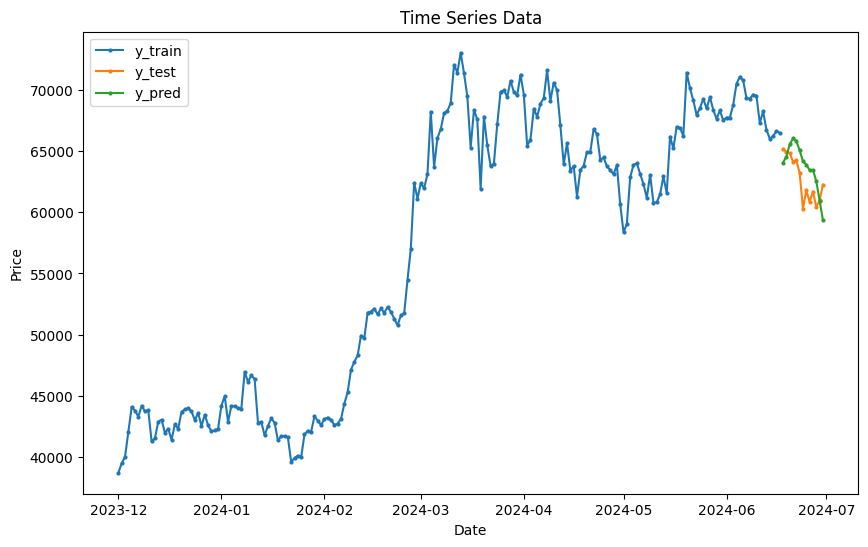

In [18]:
# Plot the predictions
start = pd.to_datetime("2023-12-01")
custom_plot_series(y_train_baseline, y_test_baseline, y_pred_baseline, start=start, marker_size=2)

# Preprocessing data

## Windowing dataset

Example: Window for one week (univariate time series)
```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [20]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2503, 2503)

In [22]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [4285.08 4108.37 4139.98 4086.29 4016.   4040.   4114.01] -> Label: [4316.01]
Window: [4108.37 4139.98 4086.29 4016.   4040.   4114.01 4316.01] -> Label: [4280.68]
Window: [4139.98 4086.29 4016.   4040.   4114.01 4316.01 4280.68] -> Label: [4337.44]


In [23]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [64143.56 64262.01 63210.01 60293.3  61806.01 60864.99 61706.47] -> Label: [60427.84]
Window: [64262.01 63210.01 60293.3  61806.01 60864.99 61706.47 60427.84] -> Label: [60986.68]
Window: [63210.01 60293.3  61806.01 60864.99 61706.47 60427.84 60986.68] -> Label: [62270.]


## Turning windows into training and test sets

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2002, 501, 2002, 501)

## Make a modelling checkpoint

In [25]:
def create_model_checkpoint(model_name, save_path="../models"):
    """
    Creates a callback to save the model checkpoint.

    Parameters:
    - model_name: str
        Name of the model.
    - save_path: str, optional (default="models")
        Directory to save the model file.

    Returns:
    - tf.keras.callbacks.ModelCheckpoint
        ModelCheckpoint callback object.
    """
    # Ensure model_name ends with .keras
    if not model_name.endswith('.keras'):
        model_name += '.keras'

    # Construct the filepath to save the model
    filepath = os.path.join(save_path, model_name)

    # Return ModelCheckpoint callback
    return tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                               verbose=0,
                                               save_best_only=True)

# Model 1: Dense model (window = 7, horizon = 1) 

In [26]:
# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                     
], name="model_1_dense") # give the model a name so we can save it

In [27]:
# Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [28]:
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8157.1035 - mae: 8157.1035 - val_loss: 5550.8784 - val_mae: 5550.8784
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1905.2812 - mae: 1905.2812 - val_loss: 1573.0697 - val_mae: 1573.0697
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 930.6963 - mae: 930.6963 - val_loss: 1298.2312 - val_mae: 1298.2312
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 842.5889 - mae: 842.5889 - val_loss: 1099.9990 - val_mae: 1099.9990
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 846.2115 - mae: 846.2115 - val_loss: 1126.3831 - val_mae: 1126.3831
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 858.9222 - mae: 858.9222 - val_loss: 1040.0587 - val_mae: 1040.0587
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 835.1740 - mae: 835.1740 - val_loss: 1078.2981 - val_mae: 1078.2981
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 816.8680 - mae: 816.8680 - val_loss: 1026.40

In [29]:
model_1.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 587.4119 - mae: 587.4119


[791.3914184570312, 791.3914184570312]

In [30]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("../models/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 537.8167 - mae: 537.8167


[726.7965087890625, 726.7965087890625]

In [31]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [32]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


(501,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([23929.959, 23690.252, 24620.264, 24600.996, 24377.42 , 24703.979,
        24493.662, 24224.959, 23959.46 , 23278.266], dtype=float32)>)

In [33]:
model_1_preds = tf.cast(model_1_preds, tf.float64)

In [34]:
tf.squeeze(test_labels).dtype, model_1_preds.dtype

(tf.float64, tf.float64)

In [35]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

Mean Absolute Error (MAE): 726.7966
Mean Squared Error (MSE): 1342217.3635
Root Mean Squared Error (RMSE): 1158.5410
R^2 Score: 0.9948


{'MAE': 726.7965924401198,
 'MSE': 1342217.3634906854,
 'RMSE': 1158.5410495492533,
 'R2': 0.9948255462893041}

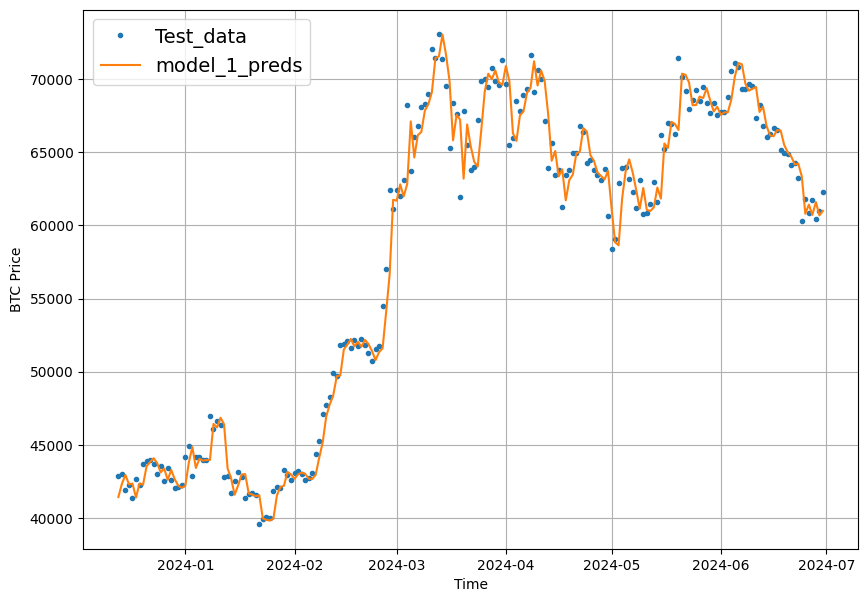

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model 2: Dense (window = 30, horizon = 1)

In [37]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [38]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2480, 2480)

In [39]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1984, 496, 1984, 496)

In [40]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [41]:
model_2.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 570.4946


760.7337036132812

In [42]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("../models/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 570.4946


760.7337036132812

In [43]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


In [44]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

Mean Absolute Error (MAE): 760.7336
Mean Squared Error (MSE): 1431390.6521
Root Mean Squared Error (RMSE): 1196.4074
R^2 Score: 0.9945


{'MAE': 760.7336198966733,
 'MSE': 1431390.6521406847,
 'RMSE': 1196.4073938841589,
 'R2': 0.9944792463715502}

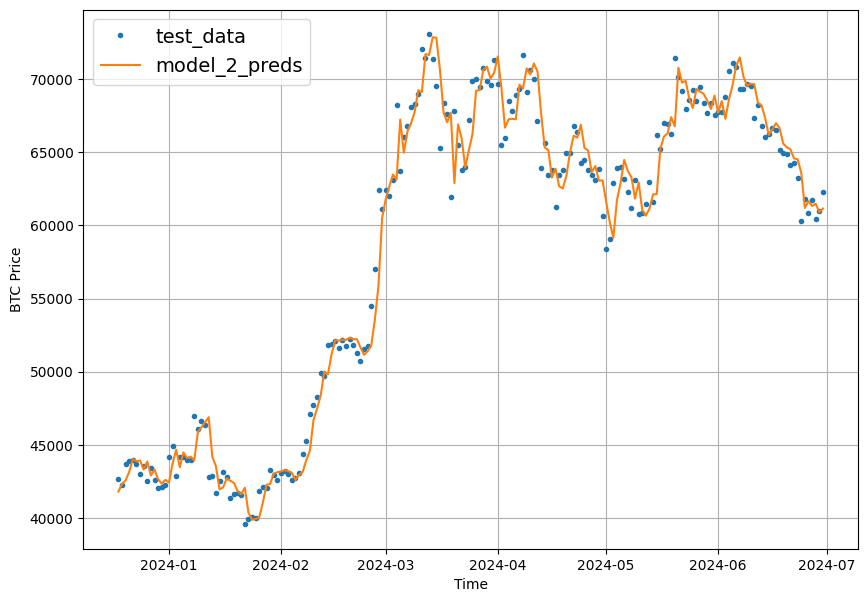

In [45]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

# Model 3: Dense (window = 30, horizon = 7)

In [46]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2474, 2474)

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1979, 495, 1979, 495)

In [48]:
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [49]:
model_3.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 1215.3574


1552.4278564453125

In [50]:
# Load in saved best performing model_3 and evaluate on test data
model_3 = tf.keras.models.load_model("../models/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 1187.3932


1518.5211181640625

In [51]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


In [52]:
test_labels.shape, model_3_preds.shape

((495, 7), TensorShape([495, 7]))

In [53]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

Mean Absolute Error (MAE): 1518.5210
Mean Squared Error (MSE): 5156150.2375
Root Mean Squared Error (RMSE): 2270.7158
R^2 Score: 0.9801


{'MAE': 1518.521036728896,
 'MSE': 5156150.237468163,
 'RMSE': 2270.71579848033,
 'R2': 0.9800591682118837}

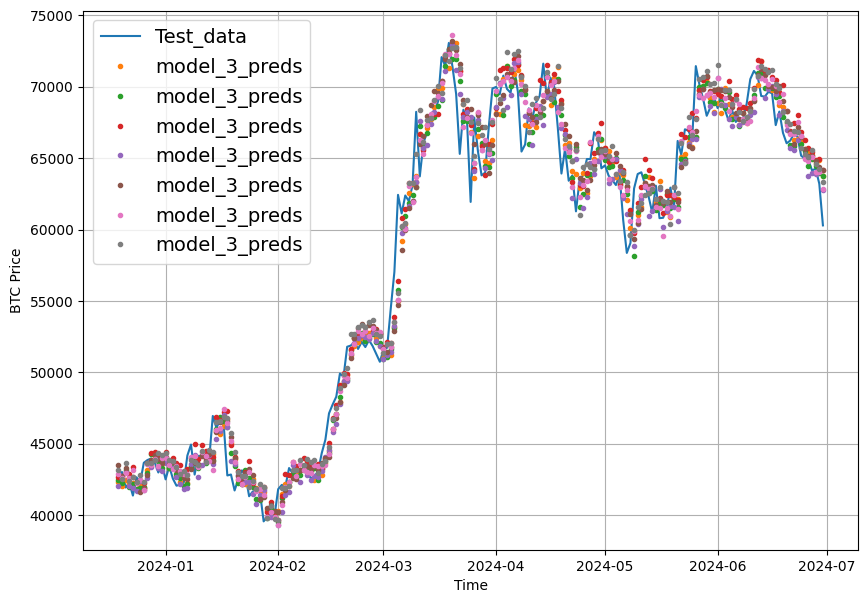

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], format="-", values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

Reduce the dimensionality of model_3 preds with ```tf.reduce.mean(...)```

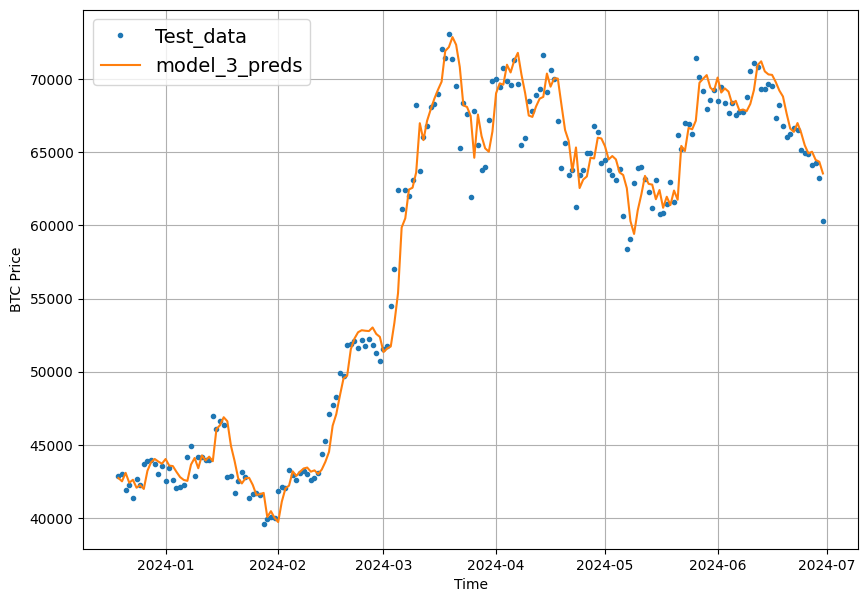

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 format=".",
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

Which model is performing best so far?

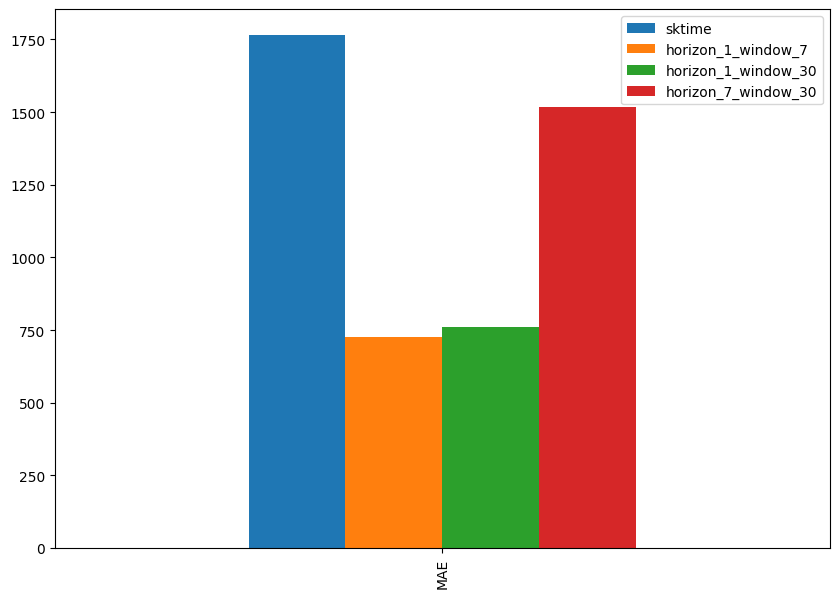

In [56]:
pd.DataFrame({"sktime": model_0_results["MAE"], 
              "horizon_1_window_7": model_1_results["MAE"], 
              "horizon_1_window_30": model_2_results["MAE"], 
              "horizon_7_window_30": model_3_results["MAE"]}, index=["MAE"]).plot(figsize=(10, 7), kind="bar");

# Model 4: Conv1D

In [57]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [58]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2503, 2503)

In [59]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2002, 501, 2002, 501)

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In [60]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[4285.08]
 [4108.37]
 [4139.98]
 [4086.29]
 [4016.  ]
 [4040.  ]
 [4114.01]]


In [61]:
# Create model
model_4 = tf.keras.Sequential([
    layers.Input(shape=(7,)),  # Define input shape explicitly
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [62]:
model_4.summary()

Model: "model_4_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [63]:
# Get forecast predictions
model_4_preds = make_preds(model_4,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [64]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

Mean Absolute Error (MAE): 905.8595
Mean Squared Error (MSE): 1747225.1314
Root Mean Squared Error (RMSE): 1321.8264
R^2 Score: 0.9933


{'MAE': 905.8595231412172,
 'MSE': 1747225.1313741715,
 'RMSE': 1321.8264376892193,
 'R2': 0.9932641792526453}

# Model 5: RNN (LSTM)

In [65]:
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=(1, 7))(inputs) # expand input dimension to be compatible with LSTM
print(x.shape)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
print(x.shape)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

(None, 1, 7)
(None, 128)


In [66]:
# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [67]:
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [68]:
model_5.summary()

Model: "model_5_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,381 (864.77 KB)

 Trainable params: 73,793 (288.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,588 (576.52 KB)

In [69]:
# Get forecast predictions
model_5_preds = make_preds(model_5,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [70]:
# Evaluate predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

Mean Absolute Error (MAE): 767.6492
Mean Squared Error (MSE): 1471988.8603
Root Mean Squared Error (RMSE): 1213.2555
R^2 Score: 0.9943


{'MAE': 767.6491797654691,
 'MSE': 1471988.860273078,
 'RMSE': 1213.2554802155555,
 'R2': 0.9943252572740272}

# Make a multivariate time series

In [73]:
btc_prices.head()

,Price
Date,
2017-08-17,4285.08
2017-08-18,4108.37
2017-08-19,4139.98
2017-08-20,4086.29
2017-08-21,4016.00


Create a DataFrame for the Bitcoin halving data

In [96]:
halving_data = {
    "": ["Halving 1", "Halving 2", "Halving 3", "Halving 4"],
    "Height of the block": [210000, 420000, 630000, 840000],
    "Date": ["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-20"],
    "Block reward (BTC)": [25, 12.5, 6.25, 3.125]
}

In [97]:
# Create a DataFrame for the Bitcoin halving data
halving_df = pd.DataFrame(halving_data)
halving_df

,,Height of the block,Date,Block reward (BTC)
0,Halving 1,210000,2012-11-28,25.000
1,Halving 2,420000,2016-07-09,12.500
2,Halving 3,630000,2020-05-11,6.250
3,Halving 4,840000,2024-04-20,3.125


 Halving 1 isn't in our dataset (it starts from 2017-08-17)

In [89]:
halving_df.dtypes

                        object
Height of the block      int64
Date                    object
Block reward (BTC)     float64
dtype: object

In [103]:
btc_prices.dtypes

Price    float64
dtype: object

In [104]:
# Convert the "Date" column to datetime format for better manipulation
halving_df['Date'] = pd.to_datetime(halving_df['Date'], errors='coerce')

# Set the Date column as the index of the DataFrame
halving_df.set_index('Date', inplace=True)

In [105]:
halving_df

,,Height of the block,Block reward (BTC)
Date,,,
2012-11-28,Halving 1,210000,25.000
2016-07-09,Halving 2,420000,12.500
2020-05-11,Halving 3,630000,6.250
2024-04-20,Halving 4,840000,3.125


In [106]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (halving_df.index[2] - btc_prices.index[0]).days
block_reward_3_days = (halving_df.index[3] - btc_prices.index[0]).days

block_reward_2_days, block_reward_3_days

(998, 2438)

In [110]:
# Add block_reward column
btc_prices_block = btc_prices.copy()
btc_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
btc_prices_block.iloc[:block_reward_2_days, -1] = halving_df['Block reward (BTC)'][1]
btc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = halving_df['Block reward (BTC)'][2]
btc_prices_block.iloc[block_reward_3_days:, -1] = halving_df['Block reward (BTC)'][3]

/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_46873/4002739709.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_prices_block.iloc[:block_reward_2_days, -1] = halving_df['Block reward (BTC)'][1]
/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_46873/4002739709.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = halving_df['Block reward (BTC)'][2]
/var/folders/vl/yrm7q8s10zl67bw31yr66mph0000gn/T/ipykernel_46873/4002739709.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

In [120]:
btc_prices_block[::365]

,Price,block_reward
Date,,
2017-08-17,4285.08,12.5
2018-08-17,6584.49,12.5
2019-08-17,10216.02,12.5
2020-08-16,11911.00,6.25
2021-08-16,45901.29,6.25
2022-08-16,23854.74,6.25
2023-08-16,28730.51,6.25


In [122]:
btc_prices_block.value_counts('block_reward')

block_reward
6.250     1440
12.500     998
3.125       72
Name: count, dtype: int64